In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [121]:
import pandas as pd
import numpy as np
from typing import Tuple, Union

def compute_maximum_drawdown(ts: pd.Series) -> Tuple[float, pd.Timestamp, pd.Timestamp]:
    """
    Compute the maximum drawdown of a time series and its start/end dates.
    
    Parameters:
    -----------
    ts : pd.Series
        A pandas Series with datetime index representing the time series
        (e.g., prices, portfolio values, etc.)
    
    Returns:
    --------
    Tuple[float, pd.Timestamp, pd.Timestamp]
        - Maximum drawdown as a percentage (negative value)
        - Start date (peak before drawdown)
        - End date (trough of drawdown)
    """
    # Ensure the series is sorted by date
    ts = ts.sort_index()
    
    # Calculate the cumulative/running maximum
    cummax = ts.expanding().max()
    
    # Calculate drawdown at each point
    drawdown = ts - cummax
    
    # Find the maximum drawdown (most negative value)
    max_drawdown = drawdown.min()
    
    # Find the date of maximum drawdown (trough)
    end_date = drawdown.idxmin()
    
    # Find the peak before this trough
    # This is the cumulative maximum value at the trough date
    start_date = ts[:end_date].idxmax()

    dates = ts[end_date:].index[ts[end_date:] >= ts[start_date]]
    if len(dates) == 0:
        recovery_date = pd.NaT
    else:
        recovery_date = dates[0]
    
    return max_drawdown, start_date, end_date, recovery_date


def compute_all_drawdowns(ts):
    """
    Compute all drawdowns of a time series and their start/end/recovery dates.

    Parameters:
    -----------
    ts : pd.Series
        A pandas Series with datetime index representing the time series

    Returns:
    --------
    List[Tuple[float, pd.Timestamp, pd.Timestamp, pd.Timestamp]]
        A list of tuples, each containing:
        - Maximum drawdown as a percentage (negative value)
        - Start date (peak before drawdown)
        - End date (trough of drawdown)
        - Recovery date (first date after trough that exceeds the peak before drawdown)
    """
    if len(ts) < 20:
        return []
    max_drawdown, start_date, end_date, recovery_date = compute_maximum_drawdown(ts)
    if max_drawdown > -0.1 and (end_date - start_date).days <= 20:
        return []
    drawdowns = [(max_drawdown, start_date, end_date, recovery_date)]
    drawdowns.extend(compute_all_drawdowns(ts[:start_date]))
    if recovery_date is not pd.NaT:
        drawdowns.extend(compute_all_drawdowns(ts[recovery_date:]))
    return drawdowns


def plot_drawdowns(ts, drawdowns, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(16, 9))
    
    ax.plot(ts)
    for _, start, end, recovery in drawdowns:
        upper_line = pd.Series(np.ones(len(ts)) * ts[start], index=ts.index)

        ax.fill_between(
            ts.loc[start:end].index, 
            upper_line.loc[start:end], 
            ts.loc[start:end],
            color='red', alpha=0.3
        )
        if recovery is not pd.NaT:
            ax.fill_between(
                ts.loc[end:recovery].index, 
                upper_line.loc[end:recovery], 
                ts.loc[end:recovery],
                color='green', alpha=0.3
            )
    return ax



In [122]:
price_df = pd.read_csv('../data/russell2000_prices.csv', index_col=0, parse_dates=True)
price_df.index = pd.to_datetime(price_df.index, utc=True)

In [123]:
ts = np.log(price_df['PRLB'])

In [126]:
drawdowns = compute_all_drawdowns(ts)
pd.DataFrame(drawdowns,columns=['drawdown','start','end','recovery']).sort_values('drawdown',ascending=False)

,drawdown,start,end,recovery
11,-0.105518,2013-08-05 04:00:00+00:00,2013-08-07 04:00:00+00:00,2013-08-22 04:00:00+00:00
13,-0.108100,2018-03-20 04:00:00+00:00,2018-04-02 04:00:00+00:00,2018-04-17 04:00:00+00:00
8,-0.113724,2013-01-18 05:00:00+00:00,2013-02-07 05:00:00+00:00,2013-02-13 05:00:00+00:00
14,-0.115327,2018-07-25 04:00:00+00:00,2018-08-01 04:00:00+00:00,2018-08-20 04:00:00+00:00
10,-0.118187,2013-10-04 04:00:00+00:00,2013-10-09 04:00:00+00:00,2013-10-17 04:00:00+00:00
6,-0.120836,2012-02-29 05:00:00+00:00,2012-03-05 05:00:00+00:00,2012-03-09 05:00:00+00:00
9,-0.137768,2013-05-10 04:00:00+00:00,2013-06-05 04:00:00+00:00,2013-06-17 04:00:00+00:00
12,-0.148361,2018-06-18 04:00:00+00:00,2018-06-27 04:00:00+00:00,2018-07-25 04:00:00+00:00
5,-0.156853,2012-04-03 04:00:00+00:00,2012-04-16 04:00:00+00:00,2012-04-27 04:00:00+00:00
7,-0.168932,2013-02-13 05:00:00+00:00,2013-02-25 05:00:00+00:00,2013-05-03 04:00:00+00:00


<Axes: >

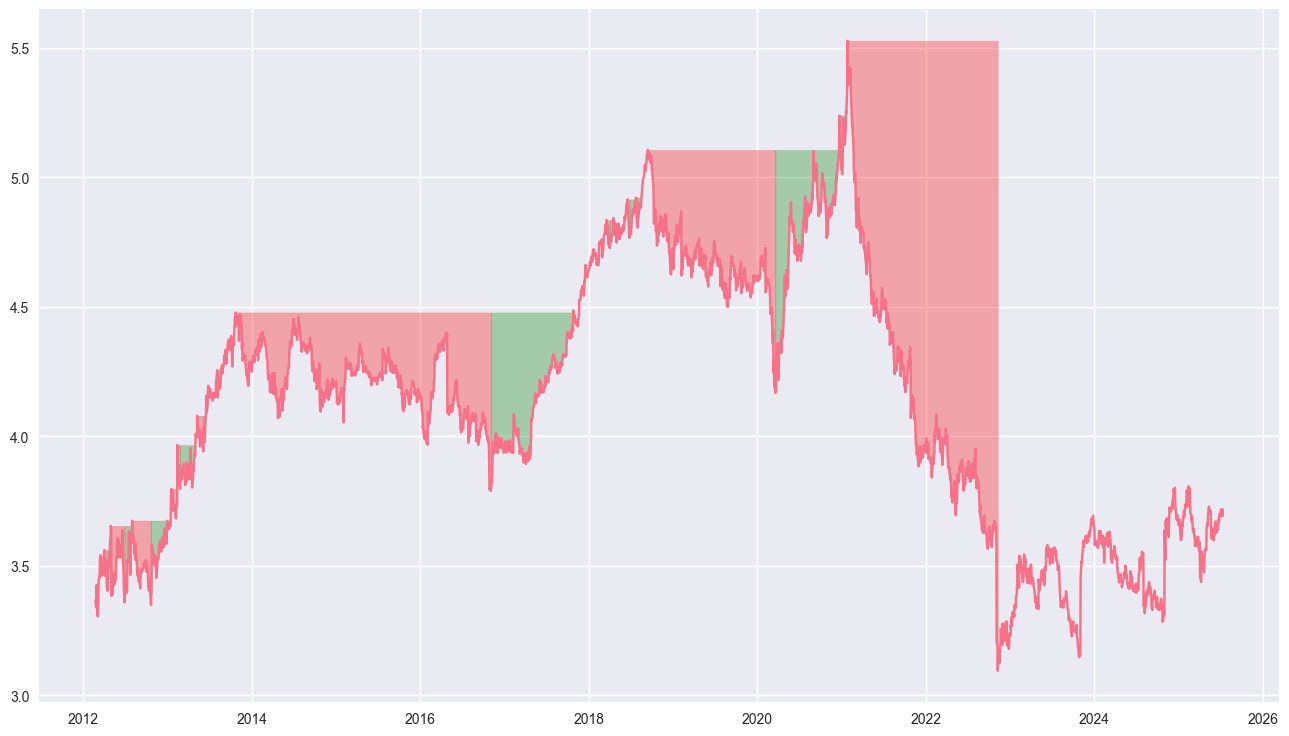

In [127]:


drawdowns = compute_all_drawdowns(ts)
plot_drawdowns(ts, drawdowns)

In [ ]:
drawdowns_df = []
for ticker in tqdm(price_df.columns):
    ts = np.log(price_df[ticker])
    df = pd.DataFrame(
        compute_all_drawdowns(ts), 
        columns=['drawdown', 'start', 'end', 'recovery']
    ).sort_values('drawdown',ascending=False)
    df['ticker'] = ticker
    drawdowns_df.append(df)
drawdowns_df = pd.concat(drawdowns_df)
drawdowns_df['recovery'] = pd.to_datetime(drawdowns_df['recovery'])
drawdowns_df.to_csv('../data/drawdowns_df.csv', index=False)

100%|██████████| 2036/2036 [00:07<00:00, 271.16it/s]


In [137]:
drawdowns_df['drawdown_duration'] = (drawdowns_df['end'] - drawdowns_df['start']).dt.days
drawdowns_df['recovery_duration'] = (drawdowns_df['recovery'] - drawdowns_df['end']).dt.days
drawdowns_df['total_duration'] = (drawdowns_df['recovery'] - drawdowns_df['start']).dt.days
drawdowns_df['drawdown_duration_ratio'] = drawdowns_df['drawdown_duration'] / drawdowns_df['total_duration']
drawdowns_df['recovery_duration_ratio'] = drawdowns_df['recovery_duration'] / drawdowns_df['total_duration']
drawdowns_df['drawdown_duration_ratio'] = drawdowns_df['drawdown_duration'] / drawdowns_df['total_duration']

<Axes: >

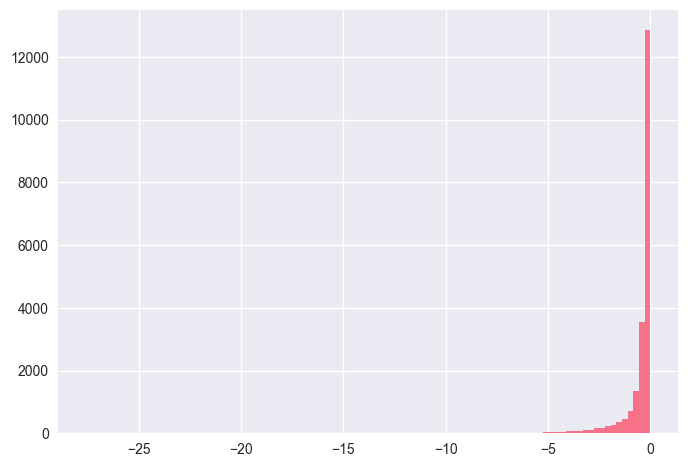

In [131]:
drawdowns_df['drawdown'].hist(bins=100)

<Axes: >

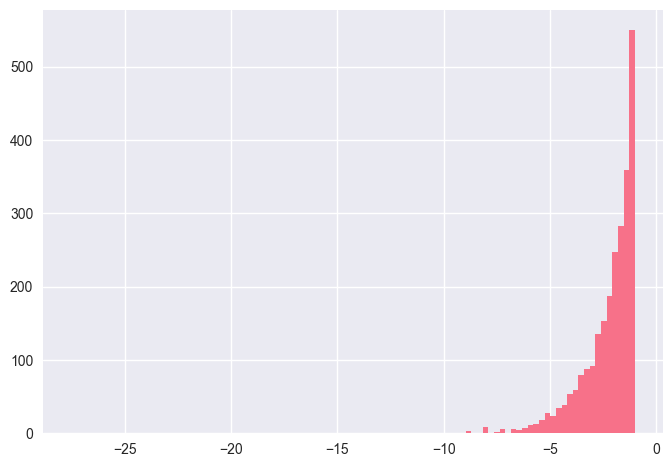

In [132]:
drawdowns_df.loc[drawdowns_df['drawdown'] < -1]['drawdown'].hist(bins=100)

<Axes: >

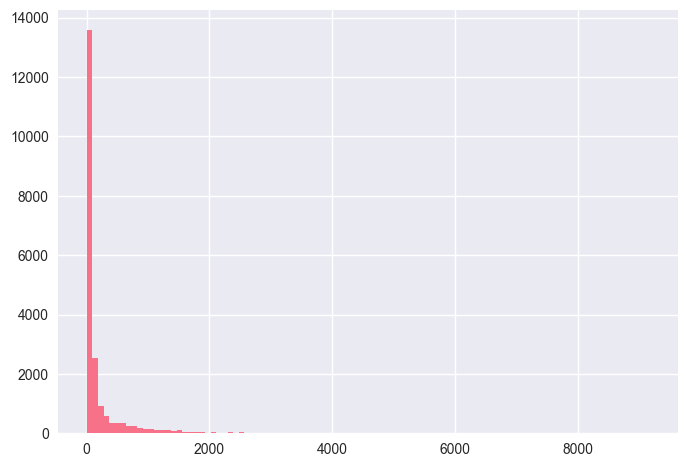

In [138]:
drawdowns_df['drawdown_duration'].hist(bins=100)

<Axes: xlabel='drawdown', ylabel='drawdown_duration'>

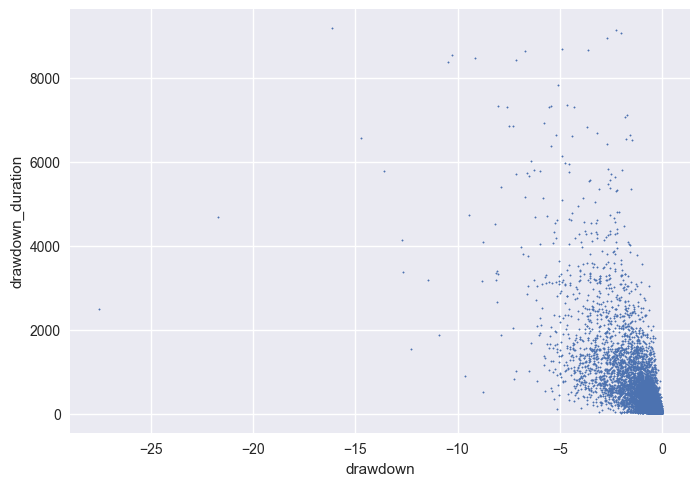

In [139]:
drawdowns_df.plot.scatter(x='drawdown', y='drawdown_duration', s=1)

<Axes: xlabel='drawdown', ylabel='recovery_duration'>

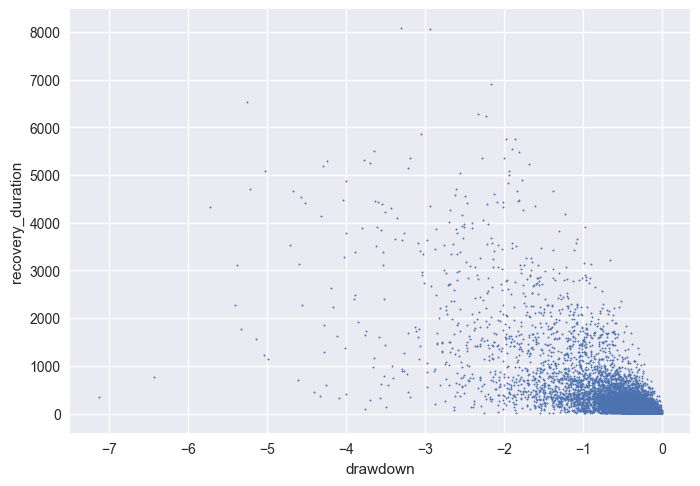

In [140]:
drawdowns_df.plot.scatter(x='drawdown', y='recovery_duration', s=1)

<Axes: xlabel='drawdown_duration', ylabel='recovery_duration'>

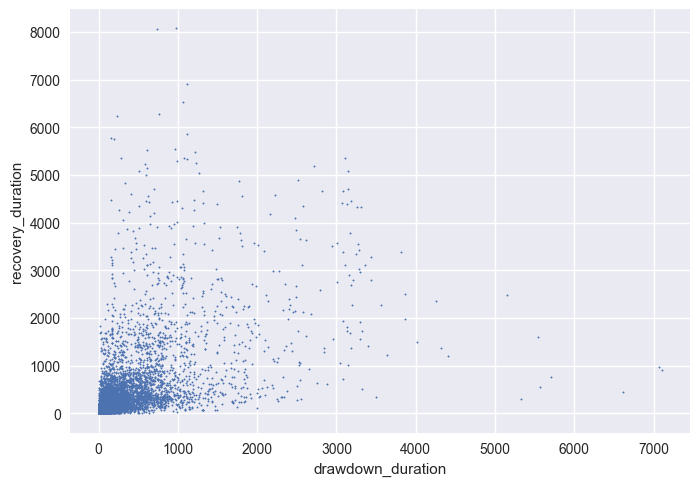

In [141]:
drawdowns_df.plot.scatter(x='drawdown_duration', y='recovery_duration', s=1)